In [1]:
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from numpy.random import poisson as poi
import time
import genSIRUniverse as gsu
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from numpy import poly1d, polyfit
import pandas as pd
import time
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import NMF, PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding, MDS
from pydiffmap import diffusion_map as dm

%matplotlib inline
%load_ext autoreload
%autoreload 2

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
#Some global definitions
state_loc = {"S":0, "I":1, "R":2}

# Objectives.
Given a set of SIR states of an ensemble of similar systems each at a particular stage of its own epidemic, can we infer the common constraints between these systems? An example could be the connectivity between the nodes, which we will hold constant within the ensemble. 

1. These constraints should reduce the possible time-states that these systems can take. This reduction is manifest in thermodynamic ensembles. For example, the fact that energy is conserved in the microcanonical ensemble leads to manifold in their phase space. This manifold, in turn, gives us the Maxwell relations between the state variables $S,T,E,p,V$. In the case of epidemics, sufficiently many time-states from a network-constrained ensemble should stitch together to form a manifold. The first objective is to attempt to make these manifolds apparent using dimensionality reduction and/or manifold learning techniques.
2. There will still be many residual degrees of freedom (d.o.f.) in this ensemble despite these constraints. These d.o.f. will probe the extent of the manifold. The second objective is to use manifold learning techniques to delineate the boundaries of the manifold. 

------
# Create an ensemble of infections confined to ring-topology.
#### Here each node is connected to other nodes that are offset by relative addresses $[-3,-2,-1,0,1,2,3]$.
For this ring-topology, the PCA reduced components also display a ring-like manifold. This latter manifold appears regardless of the degree of the connectivity. 

#### Questions.
- What is the parameter that moves states along the ring?
- There is randomness in how each epidemic was created. Where does this randomness show up in the ensemble?
- How does average population per node affect the integrity of this ring-like manifold? Do you understand why?
- Which time-state should you pick to do PCA-reduction (not just the end-state)? Is this somehow related to the average population per node? 

In [5]:
%%time
states,errs = ([],[])
universe_shape = (8,8)
(max_steps, global_alpha, global_beta, global_gamma) = (100, 0.01, 0.8, 0.2)
conn = gsu.gen_ring_connection(*universe_shape, deg_vec=[1,2,3])        
while len(errs) < 500:
    #initialise the simulation parameters
    try:
        su0 = gsu.sir_universe(universe_sh=universe_shape, conn=conn, alpha=global_alpha, 
                               beta=global_beta, gamma=global_gamma,
                              avg_pop_per_node=1000)
        su0.initialize()
        su0.iterate(max_steps)
        #Here we only select simulations that do not terminate prematurely, 
        #and also those that continue to fluctuate measurably
        err = np.asarray([np.linalg.norm(n) for n in (su0.np_state[1:]-su0.np_state[:-1])])
        if (err[-1] < 1.E-3)|(len(err)< max_steps):
            print("failed")
            continue
    except: #Sometimes the simulation fails..??
        continue
    errs.append(err.copy())
    states.append(su0.np_state.copy())
    #print('Case number {:d}'.format(len(errs)), end='\r')
states = np.asarray(states)
errs = np.asarray(errs)

CPU times: user 17.7 s, sys: 25.8 ms, total: 17.7 s
Wall time: 17.7 s


#### Examine if the large changes in each epidemic universe are completed by the end of each simulation.

Text(0,0.5,'overall change in universe')

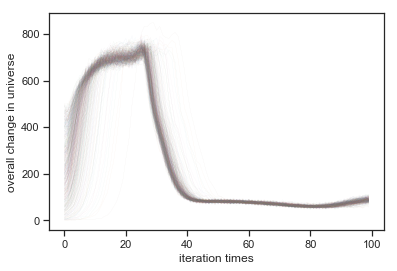

In [6]:
for n in np.random.choice(range(len(errs)),size=500, replace=False):
    plt.plot(errs[n], lw=.02)
plt.xlabel('iteration times')
plt.ylabel('overall change in universe')
#plt.yscale('log')

#### Here we see clearly the "spatiotemporal wave of infection" that propagates through any particular system.
This also helps you decide which are considered early times in the epidemics, and which are later ones.

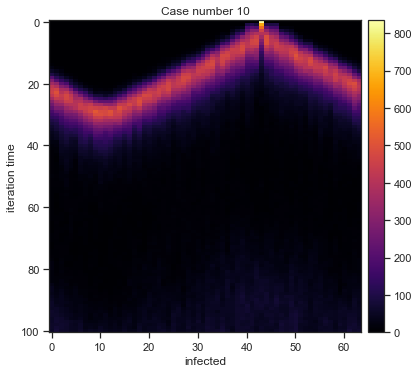

In [7]:
case_num = 10
gsu.my_single_imshow(states[case_num][:, state_loc["I"],:], 
                 xlabel="infected", ylabel="iteration time",
                title="Case number {:d}".format(case_num))

# Principal component analysis (PCA).
PCA basically looks for patterns in the covariance matrix between a large number of cases. Here, each case is a particular time-state of an epidemic spread. 
- States that are similar to each other will have a high covariance. 
- In PCA, we use Singular Value Decomposition (SVD) to decompose this case-against-case covariance matrix. 
- Cases that are 'significantly similar' to many other cases will have a large singular value after this decomposition. This singular value can be thought of as the eigenvalue of the covariance matrix. In the implementation below, these eigenvalues are termed ```explained variance``` because the *explain the variation in the data*. 

#### PCA of particular states of the infection ensemble $t^\ast$ iterations after the appearance of the first infection. 
Different $t^\ast$ give different perspectives of the system. 
- Early $t^\ast$ show how sites experience the first wave of infections. This gives us some clues about how the network is connected. 
- Very late $t^\ast$ likely only show random fluctuations residual after many waves of infections have passed through the universe.

#### First, we look at the early $t^\ast = 15$ states. 
The 'eigenvalues' of the PCA (actually, these are more like the singular values of the covariance matrix) shows that there are effectively 5-6 degrees of freedom in the system.
- What do these 5-6 degrees of freedom correspond to? 
- How will these degrees of freedom change as you increase/decrease the degree (i.e. number of connections) of each node on the ring? *Hint: what happens when all the nodes are tightly connected so that it functions as though it were a single compartment?*

In [125]:
it_num = 15
input_arr = states[:, it_num, state_loc["I"]]
pca_model, pca_transformed_input = gsu.pca_and_view(input_arr, num_components=30, plot=False)

#### The eigenvectors of the PCA can be visualized on the grid.
- Recall the decomposition naturally makes these eigenvectors orthonormal.
- The spatial extent of the eigenvectors with the largest eigenvalues, however, give us a sense of average spatial extent of the infection features on the universe during that time point. For example, the lowest eigenvector belows describes how much more the top half of the epidemic universe are infected compared to the bottom half. 

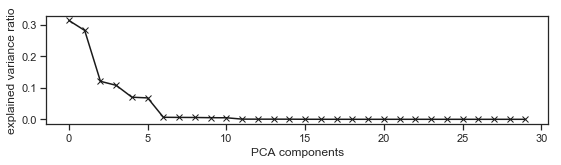

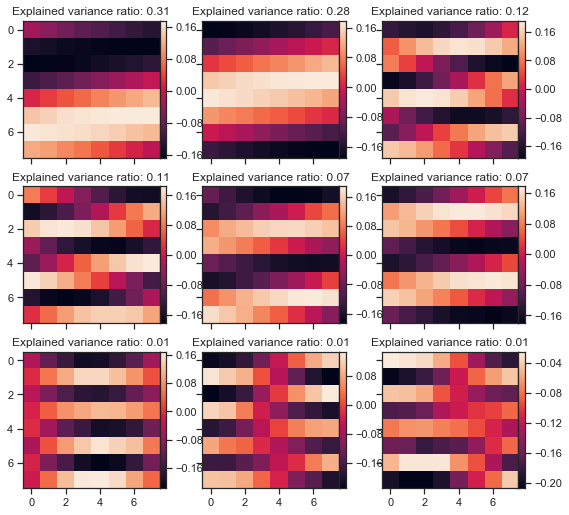

In [126]:
gsu.view_pca_2(pca_model, universe_shape, show_shape=(3,3))

#### We can then use the PCA components of the ensemble to sort and visualize the ensemble. 
These PCA components estimate the number of independent degrees of freedom in the system.  

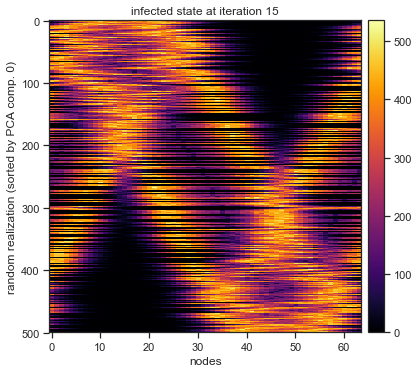

In [128]:
pca_sort_component = 0
ordering = np.argsort(pca_transformed_input[:,pca_sort_component])

gsu.my_single_imshow(input_arr[ordering],
                xlabel="nodes",
                ylabel="random realization (sorted by PCA comp. {:d})".format(pca_sort_component),
                title="infected state at iteration {:d}".format(it_num))

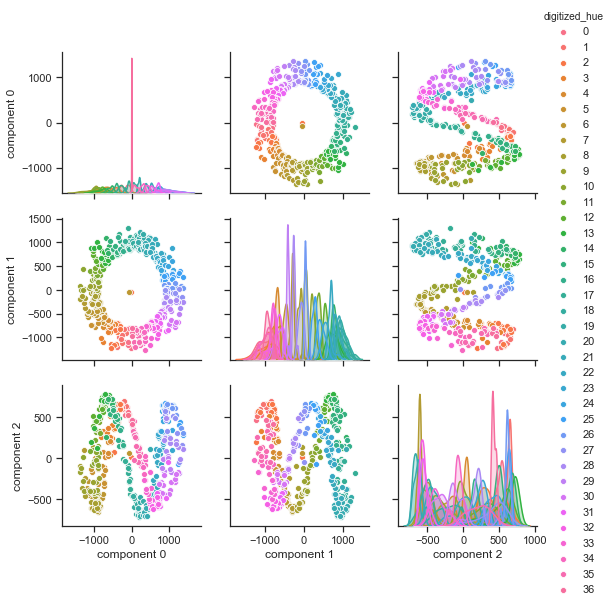

In [129]:
num_comp_to_show = 3
df = pd.DataFrame(pca_transformed_input)
df.columns = ["component {:d}".format(i) for i in range(len(pca_transformed_input.T))]
df['digitized_hue'] = ((181+180*np.arctan2(df["component 0"], df["component 1"])/np.pi)/10.).astype('int')
g = sns.pairplot(df, vars=["component {:d}".format(d) for d in range(num_comp_to_show)], hue="digitized_hue")

### We use tSNE (t-distributed stochastic neighbor embedding) to learn the manifold from these snapshots.  
Evidently, when the manifold is simple, randomly initialized tSNE (with sufficiently large perplexity) finds the same ring-like structure as PCA. The t-SNE plots below are colorized according to the coordinates found independently by PCA (above).

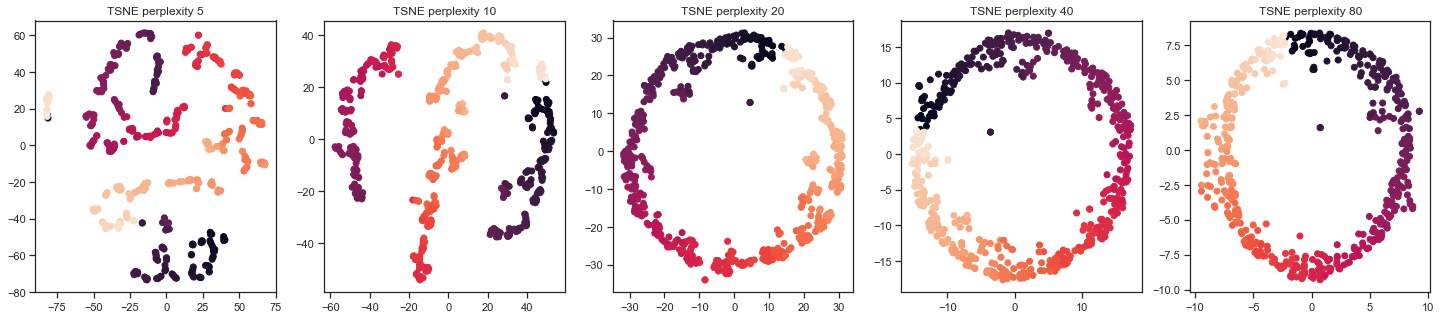

In [130]:
fig,axes = plt.subplots(1,5, figsize=(25,5))
hue_array = df['digitized_hue']

for p,ax in zip([5,10,20,40,80], axes.ravel()):
    node_position_model = TSNE(n_components=2, init='random', perplexity=p)
    embedding = node_position_model.fit_transform(input_arr)

    ax.scatter(embedding[:,0], embedding[:,1], c=hue_array)
    ax.set_title("TSNE perplexity {:d}".format(p))

#### Next we look at the late $t^\ast$ states. In fact, it's the last iteration of each epidemic simulation.

In [131]:
it_num = -1
input_arr = states[:, it_num, state_loc["I"]]
pca_model, pca_transformed_input = gsu.pca_and_view(input_arr, num_components=30, plot=False)

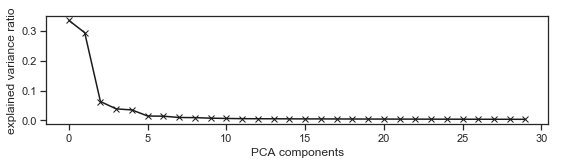

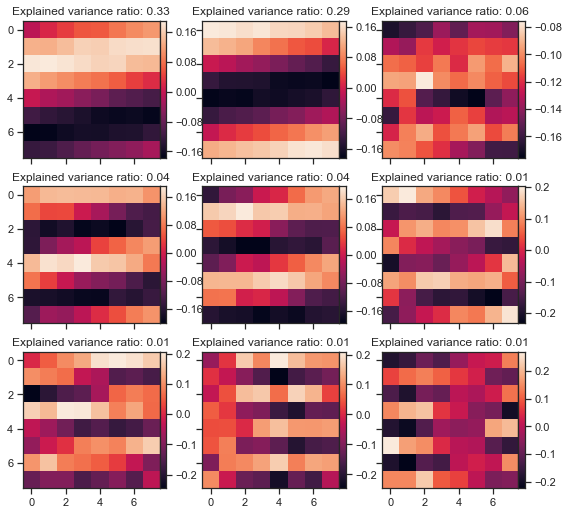

In [132]:
gsu.view_pca_2(pca_model, universe_shape, show_shape=(3,3))

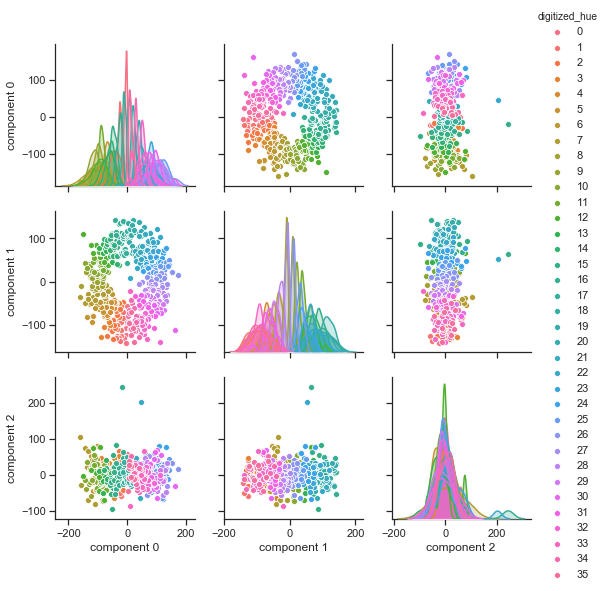

In [133]:
num_comp_to_show = 3
df = pd.DataFrame(pca_transformed_input)
df.columns = ["component {:d}".format(i) for i in range(len(pca_transformed_input.T))]
df['digitized_hue'] = ((181+180*np.arctan2(df["component 0"], df["component 1"])/np.pi)/10.).astype('int')
g = sns.pairplot(df, vars=["component {:d}".format(d) for d in range(num_comp_to_show)], hue="digitized_hue")

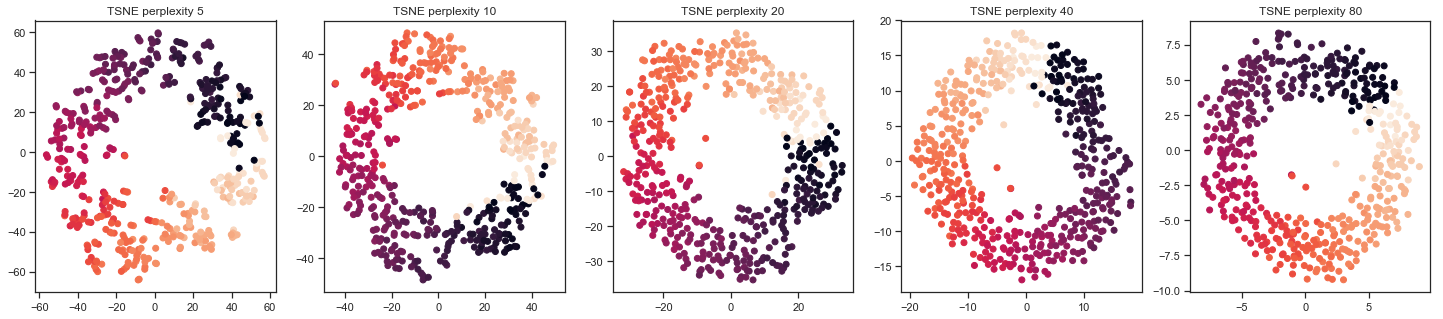

In [134]:
fig,axes = plt.subplots(1,5, figsize=(25,5))
hue_array = df['digitized_hue']

for p,ax in zip([5,10,20,40,80], axes.ravel()):
    node_position_model = TSNE(n_components=2, init='random', perplexity=p)
    embedding = node_position_model.fit_transform(input_arr)

    ax.scatter(embedding[:,0], embedding[:,1], c=hue_array)
    ax.set_title("TSNE perplexity {:d}".format(p))

### Some thoughts.
The manifolds of later-state ensembles are more 'diffuse' (i.e. broader) compared to those from early-state ensembles. This broadening is largely because the later waves of infections have smaller magnitudes, which also tend to be noisier (i.e. smaller variance-to-mean ratio). 
- We can also broaden the manifold by reducing the average population per node, or the connectivity of the nodes on the ring.